In [3]:
%reload_ext autoreload
%autoreload 2

import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import keras
from keras import layers, ops
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models import MultiInputModel

## GAN

In [ ]:
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

max_epochs = 10000
n_features = 1
latent_dim = 64

reusable_pbar = tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              d_optimizer=keras.optimizers.Adam(0.001),
              g_optimizer=keras.optimizers.Adam(0.001))

history = model.fit(
    x,
    epochs=max_epochs,
    verbose=0, # type: ignore
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='d_loss', mode='min', patience=max_epochs // 10),
        keras.callbacks.CSVLogger('tmp/keras_logs/simple_gan_v1.csv'),
        ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar),
    ]
)

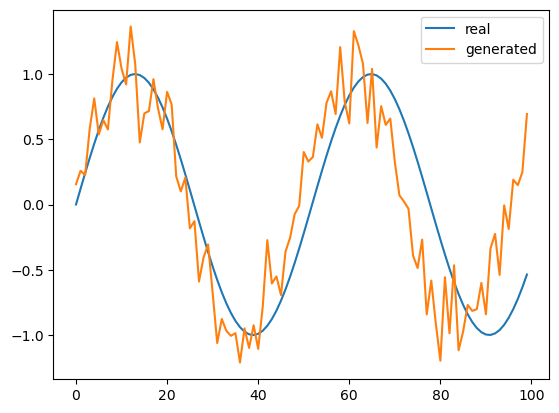

In [18]:
from matplotlib import pyplot as plt
subject_to_plot = 0
feature_to_plot = 0
plt.plot(x[subject_to_plot, :, feature_to_plot], label='real')
noise = keras.random.normal((1, latent_dim))
x_gen = model.generator(noise)
plt.plot(x_gen[subject_to_plot, :, feature_to_plot].cpu().detach().numpy().squeeze(), label='generated')
plt.legend()
plt.show()

## Load model from checkpoints

In [ ]:
from src.EEGModalNet.models import SimpleGAN
model = SimpleGAN(time_dim=100, feature_dim=1, latent_dim=64)
model.load_weights('tmp/keras_models/simple_gan_v1_HPC.model.keras')